### Toffoli solution to $y_3$ popcount problems

In this notebook we look at how the popcount problem can be solved for j=3. It looks like we can apply the same strategy as with the $y_2$ output where we used the toffoli gate to capture pairs of set bits. 
The $y_3$ output is also a periodic function like $y_1 = \omega(z)\; \%\; 2$ where the period is 2 and $y_2 = \omega(z) \;\%\; 4$ where the period is 4. The $y_3$ has period 8: $y_3 = \omega(z)\;\%\;8$
The $y_2$ output can be solved by probing all possible input qubit pairs with toffolis for $n < 6$ because the toffoli only taking effect if at least two bits are set. Now, for the case n=4 we have only one case where $y_3$ should be set: $z=1111_2$.
It is cleare that if we could construct a circuit where all four bits are controll bits and the output is the target, we would have a solution. In this notebook we will invesigate a decomposition of this gate to a gate that uses two toffolis and one X gate.

In [95]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer.primitives import Sampler
import copy
import pandas as pd

The spesific problem instance is defined:

In [96]:
# problem definition
n = 4

Function to prepare the initial states of the circuit. It takes a numpy array (input_boolean) containing booleans representing the binary string that should be prepared:

In [97]:
def prepare_input_state(input_boolean: np.ndarray, qreg: QuantumRegister, qc: QuantumCircuit): 
    for i, set_bit in enumerate(np.flip(input_boolean)):
        # For each bit in the bit string
        if set_bit:
            # If the bit is set (True), then apply the bit flip to the corresponding qubit
            qc.x(qreg[i])
            

The following function creates the circuit to solve the n=4 j=3 popcount problem.

In [98]:
def quad_cnot(qreg: QuantumRegister, qreg_result: QuantumRegister, creg: ClassicalRegister, qc: QuantumCircuit):
    # This function takes the quantum circuit as argument and applies the quadrupple cnot gate to solve the n=4, j=3 popcount problem
    qc.cx(qreg[2], qreg_result)
    qc.x(qreg[2])
    qc.ccx(qreg[0], qreg[1], qreg[2])
    qc.x(qreg[1])
    qc.ccx(qreg_result, qreg[3], qreg[1])
    qc.ccx(qreg[1], qreg[2], qreg_result)
    qc.measure(qreg_result, creg)

The next, cell is used to make a drawing of the circuit before adding input state preparation

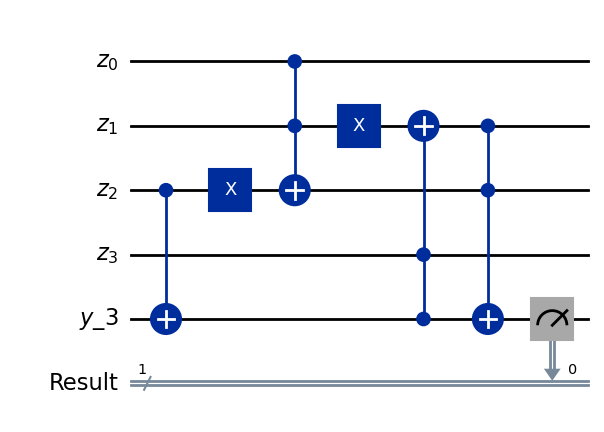

In [99]:
qreg = QuantumRegister(n, name="z")
qreg_result = QuantumRegister(1, name="y_3")
creg = ClassicalRegister(1, name="Result")
qc = QuantumCircuit(qreg, qreg_result, creg, name="popcount solution for n=4,j=3")

quad_cnot(qreg, qreg_result, creg, qc)
qc.draw("mpl")

Next, all different $2^n$ input combinations are generated an stored as numpy array

In [100]:
# The following lines generates all 2**n input combinations
input_states = np.empty((2**n, n), dtype=bool)
for i in range(2**n):
    input_states[i, :] = np.array(list(bin(i)[2:].zfill(n)), dtype=int).astype(bool)


This cell verifies that there are no redundant inputs in the list

In [101]:
test_list = []
for input_state in input_states:
    test_list.append(int("".join(input_state.astype(int).astype(str)), 2))

cur_length = len(test_list)
actual_unique_lenght = len(set(test_list))
if not (cur_length == actual_unique_lenght):
    print("There is a mistake in the generator function")

Finaly the circuit is tested by running the simulation for every possible input combination. The results are stored in a pandas dataframe and saved to a csv file in the current working directory with filename "popcount_QPE_analysis_n{n}.csv" ({n} depends on n)

In [102]:
np.flip(np.array([1,2,3]))

array([3, 2, 1])

In [103]:
results = {"Input_dec" : [], "Input_bin" : [], "Hamming_weight" : [], "Expected_output" : [], "Measured_result" : []}
for input_state in input_states:
    cur_input_decimal = int("".join(input_state.astype(int).astype(str)), 2)
    cur_hamming_weight = np.sum(input_state.astype(int))
    # Here the output bit is determined by checking if the hamming weight value has the second bit set to 1
    expected_output = int(bin(np.sum(input_state.astype(int)))[2:].zfill(n)[-3])
    # Instantiate the registers and circuit objects
    cur_qreg = QuantumRegister(n, name="z")
    cur_qreg_result = QuantumRegister(1, name="y_3")
    cur_creg = ClassicalRegister(1, name="result")
    cur_qc = QuantumCircuit(qreg, cur_qreg_result, cur_creg)
    # Prepare current input state
    prepare_input_state(input_state, cur_qreg, cur_qc)
    # Create circuit
    quad_cnot(cur_qreg, cur_qreg_result, cur_creg, cur_qc)
    # Instantiate the primitive simulator and run experimenbt with 500 shots
    result = Sampler().run([cur_qc], shots=500).result()
    # Format experiment result such that it can be trasnsformed into a pandas dataframe
    results["Input_dec"].append(cur_input_decimal)
    results["Input_bin"].append("".join(input_state.astype(int).astype(str)))
    results["Hamming_weight"].append(cur_hamming_weight)
    results["Expected_output"].append(expected_output)
    # Log thge measured result. If the final state is stochastic, then 0.5 is logged to indicate the error
    measured_keys = result.quasi_dists[0].keys()
    if list(measured_keys)[0] == 1:
        cur_qc.draw('mpl')
    if len(measured_keys) > 1:
        results["Measured_result"].append(1/2)
    else:
        results["Measured_result"].append(list(measured_keys)[0])

results_df = pd.DataFrame(results)
results_df.to_csv(f"popcount_QPE_analysis_n{n}.csv")
results_df

,Input_dec,Input_bin,Hamming_weight,Expected_output,Measured_result
0,0,0000,0,0,1
1,1,0001,1,0,1
2,2,0010,1,0,0
3,3,0011,2,0,0
4,4,0100,1,0,1
5,5,0101,2,0,1
6,6,0110,2,0,1
7,7,0111,3,0,1
8,8,1000,1,0,1
9,9,1001,2,0,1


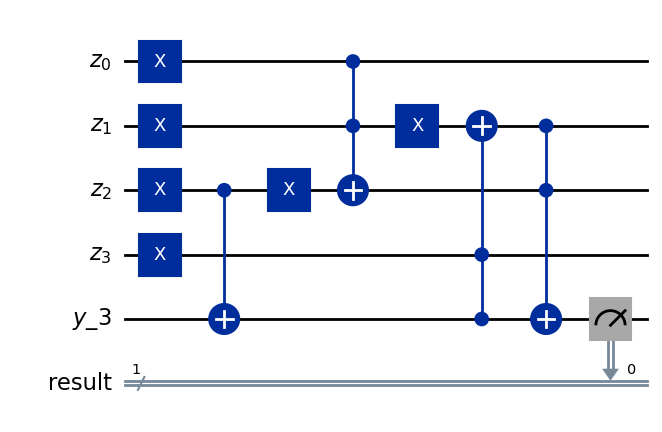

In [104]:
cur_qc.draw("mpl")

The outputs can now be verified by aggregating over the measured result and expected result by taking the mean over all cases where the hamming weight is equal. If the expected and measured results match, then the circuit is working.

In [105]:
results_df.groupby(["Hamming_weight"])[["Expected_output", "Measured_result"]].mean()

,Expected_output,Measured_result
Hamming_weight,,
0,0.0,1.000000
1,0.0,0.750000
2,0.0,0.666667
3,0.0,0.750000
4,1.0,0.000000
